In [1]:
# Data Exploration and Visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette("RdBu_r")

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation Metrics and Tuning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score, precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

### **Research Question and Motivation:** 

Can we accurately predict ventricular arrythmias based on patient characteristics and ECG wave measurements?

### **Complete Columns Metadata**

      1. Age: Age in years , linear
      2. Sex: Sex (0 = male; 1 = female) , nominal
      3. Height: Height in centimeters , linear
      4. Weight: Weight in kilograms , linear
      5. QRS duration: Average of QRS duration in msec., linear
      6. P-R interval: Average duration between onset of P and Q waves
        in msec., linear
      7. Q-T interval: Average duration between onset of Q and offset
        of T waves in msec., linear
      8. T interval: Average duration of T wave in msec., linear
      9. P interval: Average duration of P wave in msec., linear
     Vector angles in degrees on front plane of:, linear
     10. QRS
     11. T
     12. P
     13. QRST
     14. J

     15. Heart rate: Number of heart beats per minute ,linear
    
     Of channel DI:
      Average width, in msec., of: linear
      16. Q wave
      17. R wave
      18. S wave
      19. R' wave, small peak just after R
      20. S' wave

      21. Number of intrinsic deflections, linear

      22. Existence of ragged R wave, nominal
      23. Existence of diphasic derivation of R wave, nominal
      24. Existence of ragged P wave, nominal
      25. Existence of diphasic derivation of P wave, nominal
      26. Existence of ragged T wave, nominal
      27. Existence of diphasic derivation of T wave, nominal

     Of channel DII: 
      28 .. 39 (similar to 16 .. 27 of channel DI)
     Of channels DIII:
      40 .. 51
     Of channel AVR:
      52 .. 63
     Of channel AVL:
      64 .. 75
     Of channel AVF:
      76 .. 87
     Of channel V1:
      88 .. 99
     Of channel V2:
      100 .. 111
     Of channel V3:
      112 .. 123
     Of channel V4:
      124 .. 135
     Of channel V5:
      136 .. 147
     Of channel V6:
      148 .. 159

     Of channel DI:
      Amplitude , * 0.1 milivolt, of
      160 JJ wave, linear
      161 Q wave, linear
      162 R wave, linear
      163 S wave, linear
      164 R' wave, linear
      165 S' wave, linear
      166 P wave, linear
      167 T wave, linear
      
      168 QRSA , Sum of areas of all segments divided by 10,
          ( Area= width * height / 2 ), linear
      169 QRSTA = QRSA + 0.5 * width of T wave * 0.1 * height of T
          wave. (If T is diphasic then the bigger segment is
          considered), linear

     Of channel DII:
      170 .. 179
     Of channel DIII:
      180 .. 189
     Of channel AVR:
      190 .. 199
     Of channel AVL:
      200 .. 209
     Of channel AVF:
      210 .. 219
     Of channel V1:
      220 .. 229
     Of channel V2:
      230 .. 239
     Of channel V3:
      240 .. 249
     Of channel V4:
      250 .. 259
     Of channel V5:
      260 .. 269
     Of channel V6:
      270 .. 279
      
8. Missing Attribute Values: Several.  Distinguished with '?'.

9. Class Distribution:
       Database:  Arrhythmia
       
       Class code     Class                                         Number of instances
       01             Normal				                              245
       02             Ischemic changes (Coronary Artery Disease)           44
       03             Old Anterior Myocardial Infarction                   15
       04             Old Inferior Myocardial Infarction                   15
       05             Sinus tachycardy			                           13
       06             Sinus bradycardy			                           25
       07             Ventricular Premature Contraction (PVC)               3
       08             Supraventricular Premature Contraction	            2
       09             Left bundle branch block 		                        9	
       10             Right bundle branch block		                       50
       11             1. degree AtrioVentricular block	                    0	
       12             2. degree AV block		                            0
       13             3. degree AV block		                            0
       14             Left ventricule hypertrophy 	                        4
       15             Atrial Fibrillation or Flutter	                    5
       16             Others				                               22

In [2]:
#Import CSV of arrythmia data, name columns 1-280 for reference to data set documentation.
#Set the string '?' as nan value indicator. 
arrythmia_raw = pd.read_csv('Arrythmia.csv', header=None, names=np.arange(1,281, 1),  na_values=['?'])
#Check the shape of the Dataframe, the column data types and number of samples.
arrythmia_raw.shape

(452, 280)

### New Classification Categories:

Within the data set the observations are distributed into 16 catogories. Unfortunately, some groups contain very few data points making an already imbalanced data set substantially more imbalanced in classification algortihms. Since sklearn classfication models use a one-vs-all methodology (individual binary classifier for each class.)

The new classes will be:

0 = Normal Sinus Rhythm (Previously Class 1)

1 = Ischemic Changes (Previously Class 2)

2 = Old Myocardial Infarction (Previously Class 3, 4)

3 = Sinus Rhythm Abnormality (Previously Class 5, 6)

4 = Conduction Abnmormalities (Previously Class 9, 10, 14)

5 = Others (Previously Class 16)

Classes 7, 8, 11, 12, 13, and 15 dropped due to insuficient values and/or non-ventricular arrhythmias.

In [3]:
#Locate and drop rows with non-ventricular arrythmia values.
arrythmia_ventricular = arrythmia_raw.drop(arrythmia_raw.loc[(arrythmia_raw[280].isin([7, 8, 11, 12, 13, 15]))].index, 0)
arrythmia_ventricular

# def new_classes(current, new):
#     '''Takes current value of a class and replaces it with new value'''
#     arrythmia_ventricular.loc[(arrythmia_ventricular.loc[:, 280] == current), 280] = new
#     return 

# new_classes(1, 0)
# new_classes(2, 1)
# new_classes(3, 2)
# new_classes(4, 2)
# new_classes(5, 3)
# new_classes(6, 3)
# new_classes(9, 4)
# new_classes(10, 4)
# new_classes(14, 4)
# new_classes(16, 5)

# arrythmia_ventricular.head()
# #Lost 10 observations.

,1,2,3,4,5,6,7,8,9,10,...,271,272,273,274,275,276,277,278,279,280
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
5,13,0,169,51,100,167,321,174,91,107,...,-0.6,12.2,-2.8,0.0,0.0,0.9,2.2,13.5,31.1,14
6,40,1,160,52,77,129,377,133,77,77,...,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5,1
7,49,1,162,54,78,0,376,157,70,67,...,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8,1
8,44,0,168,56,84,118,354,160,63,61,...,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9,1
9,50,1,167,67,89,130,383,156,73,85,...,-0.6,10.8,-1.7,0.0,0.0,0.8,0.9,20.1,25.1,10
10,62,0,170,72,102,135,401,156,83,72,...,-0.5,9.0,-2.0,0.0,0.0,0.8,0.9,12.3,19.3,3
11,45,1,165,86,77,143,373,150,65,12,...,0.0,4.4,-2.2,0.0,0.0,0.5,1.5,4.9,17.2,1


### NaN Values Removal

In [4]:
print("Identify columns with NaN values:\n")
missing_values_columns = arrythmia_ventricular.isnull().sum()
print(missing_values_columns.loc[missing_values_columns >= 1])

#Isolate these columns in a dataframe to explore
nan_cols = arrythmia_ventricular[[11, 12, 13, 14]]
print()
print('Index of NaN Value Column 13:\n')
print(f'{nan_cols[13].loc[nan_cols[13].isnull() == True]}')

Identify columns with NaN values:

11      8
12     17
13      1
14    370
dtype: int64

Index of NaN Value Column 13:

241   NaN
Name: 13, dtype: float64


Columns 11, 12, and 14 represent, T Wave, P wave, and J point vector angles. They are not normally used in diagnosis and will be dropped due to multiple missing values.



In [5]:
ventricular_nonans = arrythmia_ventricular.drop(columns=[11, 12, 14])

#Drop the NaN value rows from dataframe to keep column 13 and 15 (QRST Vector and Heart Rate)
#Both important factors in diagnosis
#ventricular_nonans = ventricular_nonans.drop(arrythmia_raw.index[[4, 241]])
ventricular_nonans = ventricular_nonans.dropna(subset=[13])

In [6]:
#Updated dataframe information, no more NaN values.
ventricular_nonans.shape


(441, 277)

# Data Explorations: Mutual Features

## Non - ECG Features: 

 1 Age: Age in years , linear
 
 3 Height: Height in centimeters , linear
 
 4 Weight: Weight in kilograms , linear
 
 15 Heart Rate: Beat Per Minute

In [7]:
#Isolate and name non ecg continuous features in a dataframe
nonecg = ventricular_nonans[[1, 3, 4, 15]]

#There were outliers in height, weight and, age they were removed from the original and isolated dataframes:
#Visualizations of outliers were not included to reduce the length of this notebook.
#Comment out the following them.
nonecg = nonecg.loc[(nonecg[3] < 200) & (nonecg[1] > 7) & (nonecg[4] < 150)]

ventricular_nonans = ventricular_nonans.loc[(ventricular_nonans[3] < 200) & (ventricular_nonans[1] > 7) 
                                            & (ventricular_nonans[4] < 150)]


# nonecg['BMI'] = round((nonecg['Weight'] / nonecg['Height'] ** 2) * 10000, 1) 
# BMI was highely correlated with Height and Weight as expected but is not a good measure to represent them both, so it was removed.

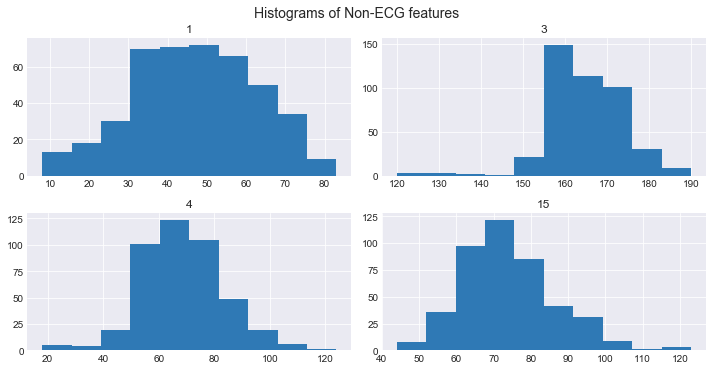

Descriptive Statistics for Non ECG continuous features:
               1           3           4           15
count  433.000000  433.000000  433.000000  433.000000
mean    46.773672  164.249423   68.570439   73.637413
std     15.652758    9.128083   14.539227   12.307412
min      8.000000  120.000000   18.000000   44.000000
25%     36.000000  160.000000   59.000000   65.000000
50%     46.000000  164.000000   68.000000   72.000000
75%     58.000000  170.000000   79.000000   81.000000
max     83.000000  190.000000  124.000000  123.000000


In [8]:
nonecg.hist(figsize=(10,5))
plt.tight_layout()
plt.suptitle('Histograms of Non-ECG features', y=1.02, fontsize=14)
plt.show()
print('Descriptive Statistics for Non ECG continuous features:')
print(nonecg.describe())

**Age (1):** Seems to follow a relatively normal distribution.

**HR(15):** Has some higher values but are within the range of possible arrythmias, so those values will be kept.

**Height(3):** Height was left skewed due to outliers the X-axis reached a maximum of 800, by limiting maximum height to 200cm we have removed the extreme values and made the distribution somewhat better. Multiple tranformations were attempted (log, sqrt, square, 1/x)

**Weight(4):** Weight had one extreme value that was removed by capping weight at 150kg. 


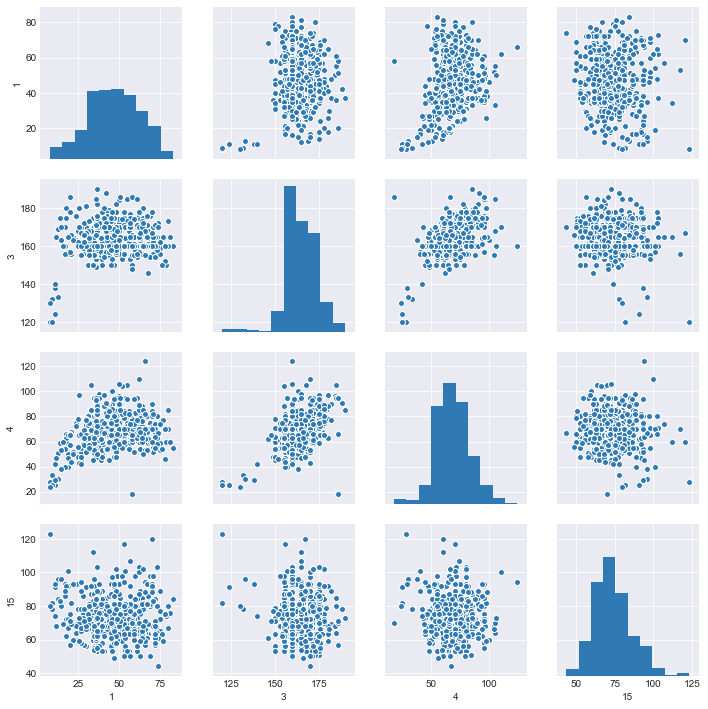

In [9]:
sns.pairplot(nonecg, diag_kind='hist')
plt.show()

In this plot we can observe the distribution of each of these Non ECG feature in the diagonal as well as the scatter plots of their relationships in the offdiagonals, after correcting for outliers. The only correlated features that can be seen here are height and weight which is expected, while they probably have shared variance they will be kept as seperate measurements.

In [10]:
#Scale nonecg features for use in model, prior to adding 'Sex' column.
nonecg = pd.DataFrame(StandardScaler().fit_transform(nonecg))


nonecg = nonecg.rename({0: 'Age', 1: 'Height', 2: 'Weight', 3: 'HR'}, axis=1)
nonecg['Sex'] = ventricular_nonans[2]

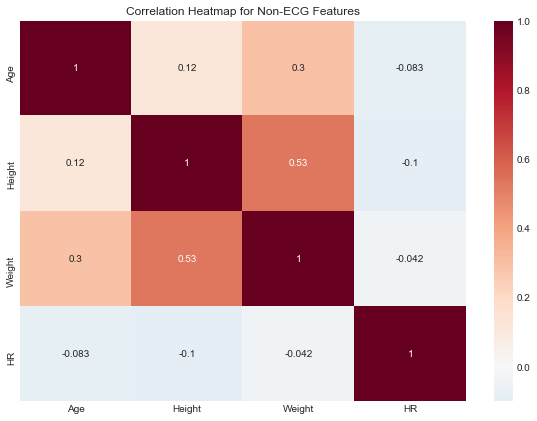

In [11]:
# Correlation heatmap for non ecg features
plt.figure(figsize=(10,7))
sns.heatmap(nonecg.iloc[:,0:4].corr(), annot=True, center=0, cmap='RdBu_r')
plt.title('Correlation Heatmap for Non-ECG Features')
plt.show()
# nonecg_fig = nonecg_heatmap.get_figure()
# nonecg_fig.savefig('nonecg.png')

### Average duration of waves and intervals ECG:

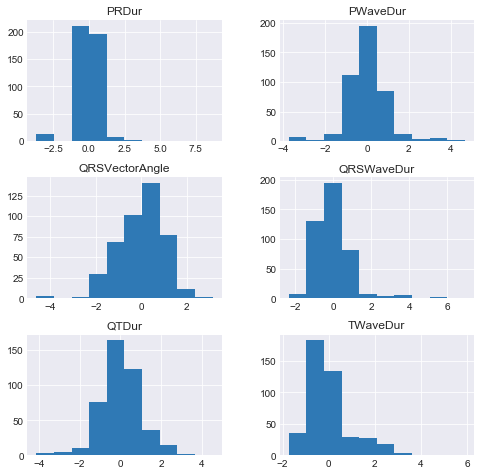

In [12]:
#Select and Standardize average durations of intervals and waves.
durations_ms = ventricular_nonans.loc[:, [5, 6, 7, 8, 9, 10]]
durations_ms = pd.DataFrame(StandardScaler().fit_transform(durations_ms))
durations_ms = durations_ms.rename(columns={0: 'QRSWaveDur', 1: 'PRDur', 2: 'QTDur', 3: 'TWaveDur', 4: 'PWaveDur', 5: 'QRSVectorAngle'})
durations_ms.hist(figsize=(8,8))
plt.show()

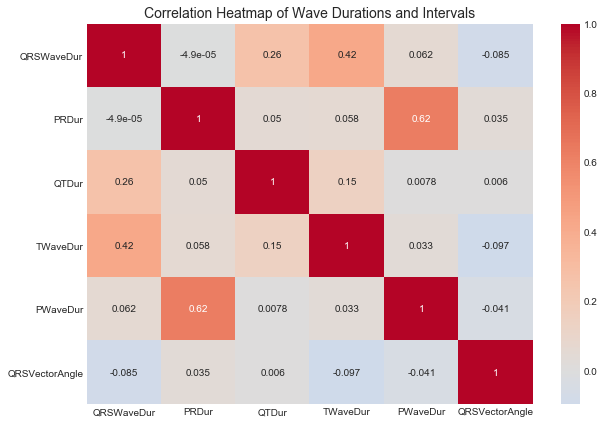

In [13]:
plt.figure(figsize=(10, 7))
sns.heatmap(durations_ms.corr(),  annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Wave Durations and Intervals', fontsize=14)
plt.show()

## Average duration of components of QRS wave by location

### Inferior Leads Durations

In [14]:
#Function to select and normalize leads from given list.
def select_normalize(leads):
    leads = ventricular_nonans.loc[:, np.concatenate(leads)]
    leads = pd.DataFrame(StandardScaler().fit_transform(leads))
    return leads

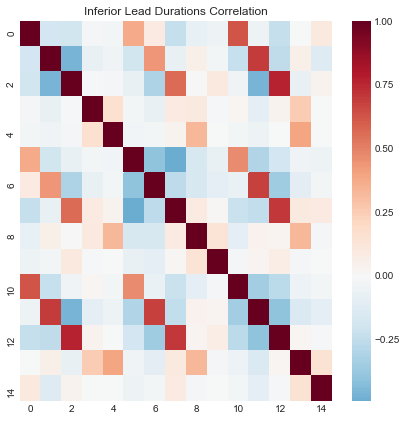

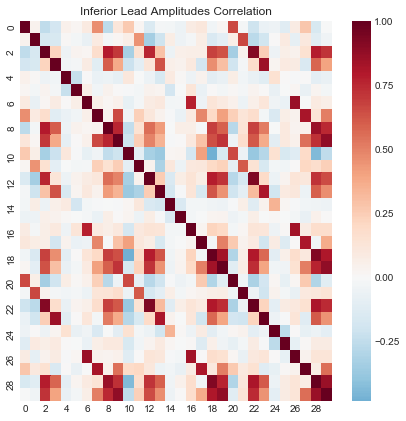

In [15]:
# Inferior Leads DII, DIII, AVF 
inferior = [np.arange(28,33,1), np.arange(40, 45,1), np.arange(76,81,1)]
inferior_leads = select_normalize(inferior)
plt.figure(figsize=(7, 7))
plt.title('Inferior Lead Durations Correlation')
sns.heatmap(inferior_leads.corr(), xticklabels=2, yticklabels=2, cmap='RdBu_r', center=0)
plt.show()

inferior_amps = [np.arange(170, 180, 1), np.arange(180, 190, 1), np.arange(210, 220, 1)]
inferior_amps = select_normalize(inferior_amps)
plt.figure(figsize=(7, 7))
plt.title('Inferior Lead Amplitudes Correlation')
sns.heatmap(inferior_amps.corr(), xticklabels=2, yticklabels=2, cmap='RdBu_r', center=0)
plt.show()

In [16]:
pca_inferior = PCA(n_components=14) # 15
inferior_pca = pd.DataFrame(pca_inferior.fit_transform(inferior_leads))
print(pca_inferior.explained_variance_ratio_.sum())

pca_inferior_amps = PCA(n_components=22) # 30
inferior_amps_pca = pd.DataFrame(pca_inferior_amps.fit_transform(inferior_amps))
print(pca_inferior_amps.explained_variance_ratio_.sum())

0.9951452225801416
0.9930028339168854


In [17]:
# plt.title('PCA of Inferior Leads')
# plt.plot(np.cumsum(pca_inferior.explained_variance_ratio_))

# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')

# plt.plot(np.cumsum(pca_inferior_amps.explained_variance_ratio_))
# plt.legend(labels=['pca_inferior_ms', 'pca_inferior_amps'])
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.show()

### Lateral Leads Durations

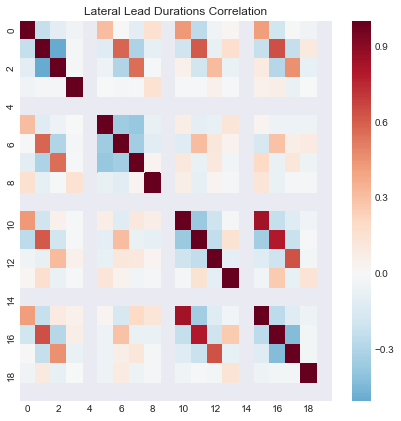

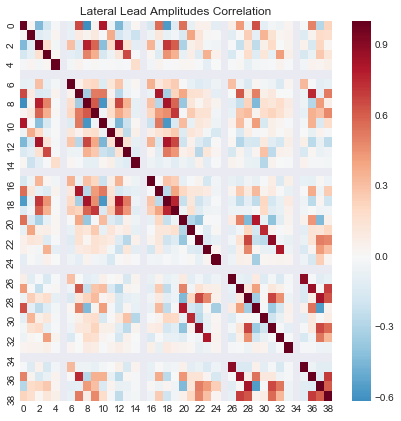

In [18]:
# Lateral Leads DI, AVL, V5, V6
lateral = [np.arange(16, 21, 1), np.arange(64, 69, 1), np.arange(136, 141, 1), np.arange(148, 153, 1)]
lateral_leads = select_normalize(lateral)
#lateral_leads = lateral_leads.drop([4, 9, 14, 19], 1)
plt.figure(figsize=(7, 7))
plt.title('Lateral Lead Durations Correlation')
sns.heatmap(lateral_leads.corr(), xticklabels=2, yticklabels=2, center=0, cmap='RdBu_r')
plt.show()

lateral_amps = [np.arange(160, 170, 1), np.arange(200, 210, 1), np.arange(260, 269, 1), np.arange(270, 280, 1)]
lateral_amps = select_normalize(lateral_amps)
#lateral_amps = lateral_amps.drop([5, 15, 25, 34], 1)
plt.figure(figsize=(7, 7))
plt.title('Lateral Lead Amplitudes Correlation')
sns.heatmap(lateral_amps.corr(), xticklabels=2, yticklabels=2, center=0, cmap='RdBu_r')
plt.show()

In [19]:
pca_lateral = PCA(n_components=15) #20
lateral_pca = pd.DataFrame(pca_lateral.fit_transform(lateral_leads))
print(pca_lateral.explained_variance_ratio_.sum())

pca_lateral_amps = PCA(n_components=26) #40
lateral_amps_pca = pd.DataFrame(pca_lateral_amps.fit_transform(lateral_amps))
print(pca_lateral_amps.explained_variance_ratio_.sum())

0.9941186817406007
0.9909750389616494


In [20]:
# plt.title('PCA of Lateral Durations and Amplitudes')
# plt.plot(np.cumsum(pca_lateral.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')


# plt.plot(np.cumsum(pca_lateral_amps.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.legend(labels=['pca_lateral_ms', 'pca_lateral_amps'])
# plt.show()

### Septal Leads

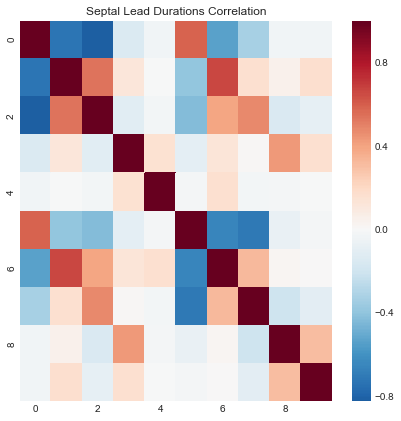

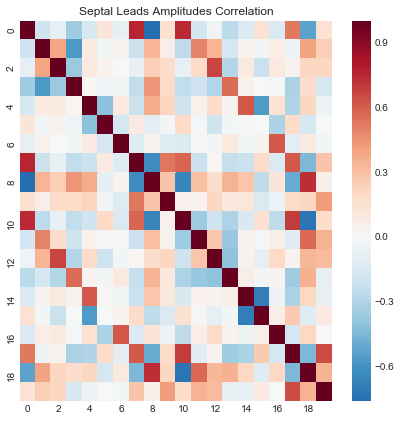

In [21]:
# Septal Leads V1 and V2
septal = [np.arange(88, 93, 1), np.arange(100, 105, 1)]
septal_leads = select_normalize(septal)
plt.figure(figsize=(7,7))
plt.title('Septal Lead Durations Correlation')
sns.heatmap(septal_leads.corr(), xticklabels=2, yticklabels=2, center=0, cmap='RdBu_r')
plt.show()


septal_amps = [np.arange(220, 230, 1), np.arange(230, 240, 1), ]
septal_amps = select_normalize(septal_amps)
plt.figure(figsize=(7, 7))
plt.title('Septal Leads Amplitudes Correlation')
sns.heatmap(septal_amps.corr(), xticklabels=2, yticklabels=2, center=0, cmap='RdBu_r')
plt.show()

In [22]:
#PCA of septal leads
pca_septal = PCA(n_components=9) #10
septal_pca = pd.DataFrame(pca_septal.fit_transform(septal_leads))
print(pca_septal.explained_variance_ratio_.sum())

pca_septal_amps = PCA(n_components=10) #20
septal_amps_pca = pd.DataFrame(pca_septal_amps.fit_transform(septal_leads))
print(pca_septal_amps.explained_variance_ratio_.sum())

0.9973297772315508
0.9999999999999999


In [23]:
# plt.title('PCA of Septal Durations and Amplitudes')
# plt.plot(np.cumsum(pca_septal.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')


# plt.plot(np.cumsum(pca_septal_amps.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.legend(labels=['pca_lateral_ms', 'pca_lateral_amps'])
# plt.show()

### Anterior Leads Durations

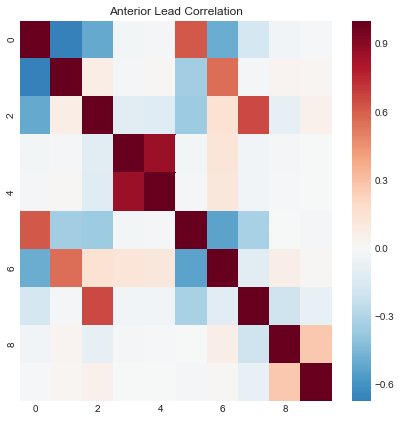

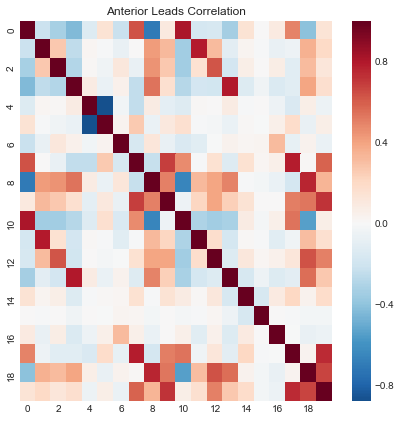

In [24]:
# Anterior Leads V3, V4
anterior = [np.arange(112, 117, 1), np.arange(124, 129, 1)]
anterior_leads = select_normalize(anterior)
plt.figure(figsize=(7, 7))
plt.title('Anterior Lead Correlation')
sns.heatmap(anterior_leads.corr(), xticklabels=2, yticklabels=2, center=0, cmap='RdBu_r')
plt.show()

anterior_amps = [np.arange(240, 250, 1), np.arange(250, 260, 1)]
anterior_amps = select_normalize(anterior_amps)
plt.figure(figsize=(7, 7))
plt.title('Anterior Leads Correlation')
sns.heatmap(anterior_amps.corr(), xticklabels=2, yticklabels=2, center=0, cmap='RdBu_r')
plt.show()

In [25]:
#PCA of anterior leads
pca_anterior = PCA(n_components=9) #10
anterior_pca = pd.DataFrame(pca_anterior.fit_transform(anterior_leads))
print(pca_anterior.explained_variance_ratio_.sum())


pca_anterior_amps = PCA(n_components=10) #20
anterior_amps_pca = pd.DataFrame(pca_anterior_amps.fit_transform(anterior_leads))
print(pca_anterior_amps.explained_variance_ratio_.sum())

0.9924484466227064
1.0


In [26]:
# plt.title('PCA of Anterior Durations and Amplitudes')
# plt.plot(np.cumsum(pca_anterior.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')

# plt.plot(np.cumsum(pca_anterior_amps.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.legend(labels=['pca_anterior_ms', 'pca_lateral_amps'])

In [27]:
# Isolate deflection and binary indicator features for each lead.
deflections = ventricular_nonans.loc[:, [21, 33, 45, 57, 69, 81, 93, 105, 117, 129, 141, 153]]
binary = ventricular_nonans.loc[:, list(range(22, 28)) 
                                 + list(range(34, 40)) 
                                 + list(range(46, 52)) 
                                 + list(range(58, 64)) 
                                 + list(range(70, 76)) 
                                 + list(range(82, 88)) 
                                 + list(range(94, 100)) 
                                 + list(range(106, 112)) 
                                 + list(range(118, 124))
                                 + list(range(130, 136)) 
                                 + list(range(142,148))
                                 + list(range(154, 160))]

#Isolate avr related features.
avr = [np.arange(52, 57,1), np.arange(190, 200, 1)]
avr = select_normalize(avr)


#amplitudes = pd.DataFrame(StandardScaler().fit_transform(ventricular_nonans.loc[:, np.arange(160, 280, 1)]))

The cell below will contains all of the data set excluding the dropped NaN value columns and rows. Here we can organize a list for concantenating our new data set based on the explored and tranasformed variables.

In [28]:
explored = [nonecg, durations_ms, anterior_pca, anterior_amps_pca, inferior_pca, inferior_amps_pca, 
            lateral_pca, lateral_amps_pca, septal_pca, septal_amps_pca, 
deflections, 
binary, 
avr]

In [29]:
features = pd.concat(explored, 1)
features['Class'] = ventricular_nonans[280]

In [30]:
features.to_csv('ECG Features2.csv')

pd.DataFrame(StandardScaler().fit_transform(ventricular_nonans)).to_csv('raw_ecg.csv') # Saving the raw features for modelling too.

### Machine Learning Dimensionality Reduction Approach

We have a set of 120 features that represent the amplitude wave measurements, and a set of 58 features that represent

In [31]:
# amplitudes = pd.DataFrame(StandardScaler().fit_transform(ventricular_nonans.loc[:, np.arange(160, 280, 1)]))
# print(len(amplitudes.columns))

# amplitudes_pca = PCA(n_components=75)
# pca_amplitudes = pd.DataFrame(amplitudes_pca.fit_transform(amplitudes))
# print(amplitudes_pca.explained_variance_ratio_.sum())

# plt.plot(np.cumsum(amplitudes_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')

In [32]:
# leads_ms = pd.concat([inferior_leads, septal_leads, anterior_leads, lateral_leads, select_normalize([np.arange(52, 58, 1)])], 1)
# print(len(leads_ms.columns))
# lead_durations_pca = PCA(n_components=49)
# pca_lead_durations = pd.DataFrame(lead_durations_pca.fit_transform(leads_ms))
# print(lead_durations_pca.explained_variance_ratio_.sum())

# plt.plot(np.cumsum(lead_durations_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.show()

In [33]:
# ml_features = pd.concat([nonecg, durations_ms, pca_lead_durations, pca_amplitudes, deflections, binary, avr], 1).dropna()
# ml_features['Class'] = ventricular_nonans[280]

# ml_features.to_csv('ECG_ml.csv')

## Modelling

In [34]:
arrhythmia_ml = pd.read_csv('raw_ecg.csv', index_col=0)
arrhythmia_ml = arrhythmia_ml.dropna()
arrhythmia_ml['Yes/No'] = np.where(ventricular_nonans[280] > 1, 1, 0) # create a binary indicator for the presence of arrythmia

# arrhythmia_ml = pd.read_csv('ECG Features2.csv', index_col=0)
# arrhythmia_ml = arrhythmia_ml.dropna()
# arrhythmia_ml['Yes/No'] = np.where(arrhythmia_ml['Class'] > 1, 1, 0) # create a binary indicator for the presence of arrythmia

# arrhythmia_ml = pd.read_csv('ECG_ml.csv', index_col=0)
# arrhythmia_ml = arrhythmia_ml.dropna()
# arrhythmia_ml['Yes/No'] = np.where(arrhythmia_ml['Class'] > 1, 1, 0) # create a binary indicator for the presence of arrythmia

In [35]:
arrhythmia_ml.head()

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,Yes/No
0,0.590120,0.892570,0.082322,-0.314716,-0.516554,0.413867,1.036601,-0.587330,-2.144441,-0.198365,...,-0.185084,0.742827,-0.081284,0.0,-0.961774,0.629202,0.052577,0.508174,0.539591,1
1,0.462199,-1.120361,0.850074,1.819913,3.446478,0.153739,0.552128,0.421741,0.450290,1.443622,...,0.106870,-0.527866,-0.081284,0.0,-0.662171,1.557585,-0.563332,1.082690,1.471368,1
2,0.526159,-1.120361,1.179110,1.751054,0.804456,1.076010,0.358339,0.253562,2.138924,-0.128985,...,0.895144,-0.421975,-0.081284,0.0,-0.362568,0.986273,1.132320,1.792385,-0.625130,0
3,-2.160178,-1.120361,0.521037,-1.209883,0.804456,0.248331,-1.547256,0.113414,-0.002758,1.698015,...,0.895144,-0.739648,-0.081284,0.0,1.135446,0.700617,-0.472087,0.074471,2.403145,1
4,-0.433247,0.892570,-0.466071,-1.141024,-0.794662,-0.650292,0.261444,-1.035805,-0.579365,1.004217,...,-0.768990,0.742827,-0.081284,0.0,-0.362568,-0.156352,-0.411256,-0.522574,-0.625130,0


In [36]:
X = arrhythmia_ml.drop(['276', 'Yes/No'], 1)
y = arrhythmia_ml['Yes/No']

# X = arrhythmia_ml.drop(['Class', 'Yes/No'], 1)
# y = arrhythmia_ml['Yes/No']
# y_2 = arrhythmia_ml['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [37]:
# Logistic Regression
logreg = LogisticRegression(C=10, penalty='l2' )
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_probas = logreg.predict_proba(X_test)[:, 1]
print(pd.crosstab(y_test, y_pred))
print()
print(f'0.2 Test Set Accuracy: {logreg.score(X_test, y_test)}')
print(f'10-fold CV: {np.mean(cross_val_score(logreg, X, y, cv=10))}')
print(classification_report(y_test, y_pred))

col_0    0   1
Yes/No        
0       37  10
1       16  24

0.2 Test Set Accuracy: 0.7011494252873564
10-fold CV: 0.7253473270915131
             precision    recall  f1-score   support

          0       0.70      0.79      0.74        47
          1       0.71      0.60      0.65        40

avg / total       0.70      0.70      0.70        87



AUC: 0.7313829787234043


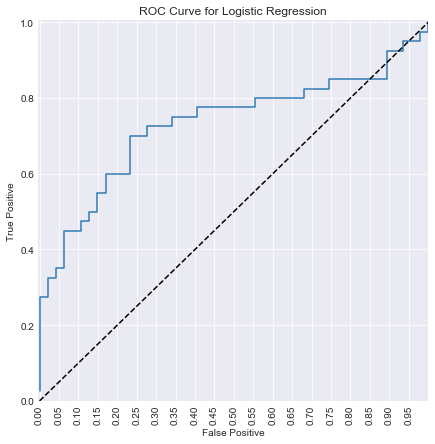

In [38]:
false_pos, true_pos, auc = roc_curve(y_test, y_probas)
plt.figure(figsize=(7,7))
plt.plot(false_pos, true_pos)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)

plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve for Logistic Regression')
print(f'AUC: {roc_auc_score(y_test, y_probas)}')
plt.show()

## SVC

In [39]:
# SVC
svc = LinearSVC(C=10)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_probas = svc.decision_function(X_test)
print(pd.crosstab(y_test, y_pred))
print()
print()

print(f'0.2 Test Set Accuracy: {svc.score(X_test, y_test)}')
print(f'10-fold CV: {np.mean(cross_val_score(svc, X, y, cv=10))}')

print(classification_report(y_test, y_pred))

col_0    0   1
Yes/No        
0       36  11
1       19  21


0.2 Test Set Accuracy: 0.6551724137931034
10-fold CV: 0.676819691935971
             precision    recall  f1-score   support

          0       0.65      0.77      0.71        47
          1       0.66      0.53      0.58        40

avg / total       0.66      0.66      0.65        87



AUC: 0.7143617021276596


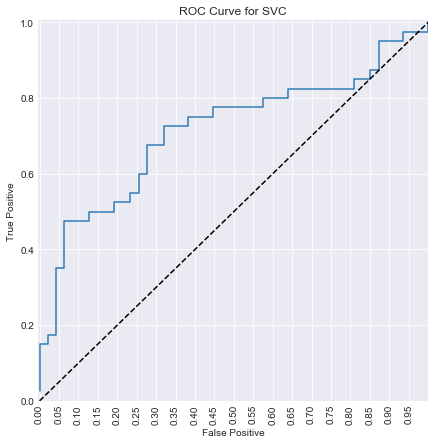

In [40]:
false_pos, true_pos, auc = roc_curve(y_test, y_probas)
plt.figure(figsize=(7,7))
plt.plot(false_pos, true_pos)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve for SVC')
print(f'AUC: {roc_auc_score(y_test, y_probas)}')
plt.show()

In [41]:
# p, r, thresholds = precision_recall_curve(y_test, y_probas)
   
# plot_precision_recall_vs_threshold(p, r, thresholds)

## Gradiant Boosting

In [42]:
parameters = {'learning_rate': [0.008, 0.01, 0.02],
              'n_estimators' : [400, 500, 600],
              'max_depth' : [2, 3]}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

gbm_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=parameters, cv=3, n_jobs=-1, scoring=scorers, refit='recall_score')
#gbm_grid2 = GridSearchCV(GradientBoostingClassifier(), param_grid=parameters, cv=3, n_jobs=-1, scoring=scorers, refit='recall_score')
gbm_grid.fit(X_train, y_train)
#gbm_grid2.fit(X2_train, y2_train)
print(gbm_grid.best_params_)
#print(gbm_grid2.best_params_)

{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 600}


In [43]:
y_pred = gbm_grid.predict(X_test)
#y_pred2 = gbm_grid2.predict(X2_test)
y_probas = gbm_grid.predict_proba(X_test)[:, 1]
y_probas2 = gbm_grid.predict_proba(X)
print(pd.crosstab(y_test, y_pred))
print()
#print(pd.crosstab(y2_test, y_pred2))
print()
print(f'0.2 Test Set Accuracy: {gbm_grid.score(X_test, y_test)}')
print(f'10-fold CV: {np.mean(cross_val_score(GradientBoostingClassifier(learning_rate=0.008, max_depth=3, n_estimators=400), X, y, cv=10))}')
print(classification_report(y_test, y_pred))
#gbm_grid2.score(X2_test, y2_test)
#cross_gbm_predictions = cross_val_predict(estimator=GradientBoostingClassifier(learning_rate=0.008,max_depth=2, n_estimators=500), X=X, y=y, cv=10)

col_0    0   1
Yes/No        
0       42   5
1       13  27


0.2 Test Set Accuracy: 0.675
10-fold CV: 0.8222314507198227
             precision    recall  f1-score   support

          0       0.76      0.89      0.82        47
          1       0.84      0.68      0.75        40

avg / total       0.80      0.79      0.79        87



AUC: 0.8819148936170212


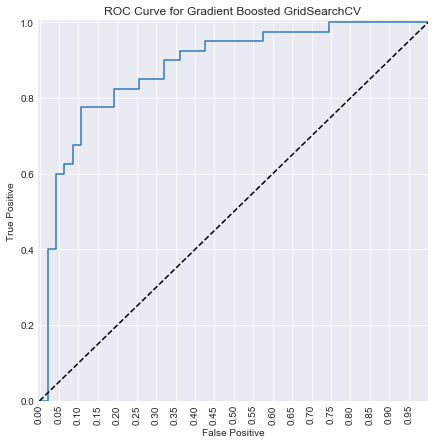

In [44]:
false_pos, true_pos, auc = roc_curve(y_test, y_probas)
plt.figure(figsize=(7,7))
plt.plot(false_pos, true_pos)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
  
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve for Gradient Boosted GridSearchCV')
print(f'AUC: {roc_auc_score(y_test, y_probas)}')
plt.show()

In [45]:
# p, r, thresholds = precision_recall_curve(y_test, y_probas)
# plot_precision_recall_vs_threshold(p, r, thresholds)

## Random Forest

In [46]:
parameters = {'n_estimators' : [1000],
              'max_depth' : [10]}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=2, n_jobs=-1)
rfc_grid.fit(X_train, y_train)
print(rfc_grid.best_params_)

{'max_depth': 10, 'n_estimators': 1000}


In [47]:
y_pred = rfc_grid.predict(X_test)
y_probas = logreg.predict_proba(X_test)[:, 1]
print(pd.crosstab(y_test, y_pred))
print(f'0.2 Test Set Accuracy: {rfc_grid.score(X_test, y_test)}')
print(f'10-fold CV: {np.mean(cross_val_score(RandomForestClassifier(max_depth=10, n_estimators=1000), X, y, cv=10))}')
print(classification_report(y_test, y_pred))

col_0    0   1
Yes/No        
0       45   2
1       16  24
0.2 Test Set Accuracy: 0.7931034482758621
10-fold CV: 0.8153654485049835
             precision    recall  f1-score   support

          0       0.74      0.96      0.83        47
          1       0.92      0.60      0.73        40

avg / total       0.82      0.79      0.78        87



AUC: 0.7313829787234043


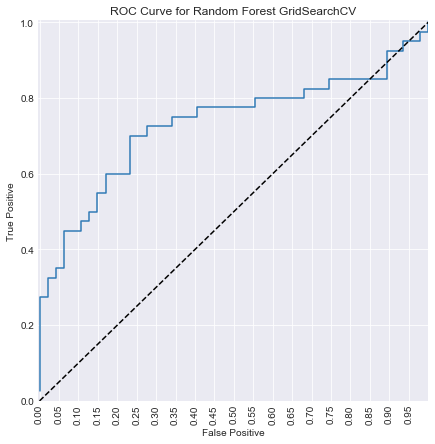

In [48]:
false_pos, true_pos, auc = roc_curve(y_test, y_probas)
plt.figure(figsize=(7,7))
plt.plot(false_pos, true_pos)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
  
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve for Random Forest GridSearchCV')
print(f'AUC: {roc_auc_score(y_test, y_probas)}')
plt.show()